# Proyek GAN - Kelompok 2

## Apa itu GAN?
Generative Adversarial Network (GAN) adalah arsitektur deep learning yang terdiri dari dua model neural network yang saling bersaing: Generator dan Discriminator.

Generator berusaha menciptakan gambar palsu yang mirip dengan data asli.
Discriminator berusaha membedakan mana gambar asli dan mana gambar buatan Generator.
    
Tujuan pelatihan GAN adalah membuat Generator cukup baik hingga Discriminator tidak bisa membedakan gambar palsu dari yang asli.

In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Buat folder untuk hasil
os.makedirs("/kaggle/working/generated_images", exist_ok=True)
os.makedirs("/kaggle/working/models", exist_ok=True)

In [4]:
# Load Dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="/kaggle/working/data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]


In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x.view(-1, 784))

In [6]:
#nisialisasi Model, Loss, dan Optimizer
generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss_function = nn.BCELoss()
lr = 0.0002

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

noise_dim = 100
fixed_noise = torch.randn(64, noise_dim, device=device)

In [7]:
#Loop Training GAN
num_epochs = 20
losses_G, losses_D = [], []

for epoch in range(1, num_epochs + 1):
    loop = tqdm(dataloader, leave=False)
    for real_images, _ in loop:
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Label
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)

        outputs_real = discriminator(real_images)
        outputs_fake = discriminator(fake_images.detach())

        loss_real = loss_function(outputs_real, real_labels)
        loss_fake = loss_function(outputs_fake, fake_labels)
        loss_D = loss_real + loss_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        loss_G = loss_function(outputs, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Update tqdm bar title
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())

    # Logging epoch
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    print(f"Epoch [{epoch}/{num_epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    # Save image
    if epoch % 10 == 0:
        with torch.no_grad():
            gen_images = generator(fixed_noise).detach().cpu()
        save_image(gen_images, f"/kaggle/working/generated_images/epoch_{epoch}.png", normalize=True)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/20] | Loss D: 0.0490 | Loss G: 5.6738


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/20] | Loss D: 0.2098 | Loss G: 5.7309


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/20] | Loss D: 0.0870 | Loss G: 5.1285


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/20] | Loss D: 0.9569 | Loss G: 3.7357


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/20] | Loss D: 0.2393 | Loss G: 3.4777


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/20] | Loss D: 0.1463 | Loss G: 3.4708


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/20] | Loss D: 0.0386 | Loss G: 4.6379


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/20] | Loss D: 0.0829 | Loss G: 4.8143


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/20] | Loss D: 0.0601 | Loss G: 11.3942


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/20] | Loss D: 0.1783 | Loss G: 6.0129


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/20] | Loss D: 0.0523 | Loss G: 6.9849


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/20] | Loss D: 0.3162 | Loss G: 7.5598


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/20] | Loss D: 0.3813 | Loss G: 7.5275


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/20] | Loss D: 0.1267 | Loss G: 3.9049


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/20] | Loss D: 0.2153 | Loss G: 4.8652


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [16/20] | Loss D: 0.3375 | Loss G: 4.3926


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [17/20] | Loss D: 0.2207 | Loss G: 3.7145


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [18/20] | Loss D: 0.2945 | Loss G: 5.2584


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [19/20] | Loss D: 0.2162 | Loss G: 4.7237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [20/20] | Loss D: 0.2961 | Loss G: 3.9203


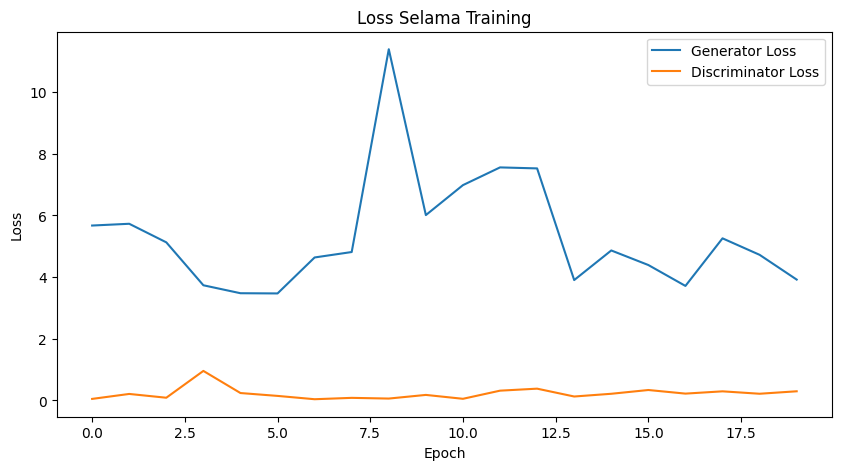

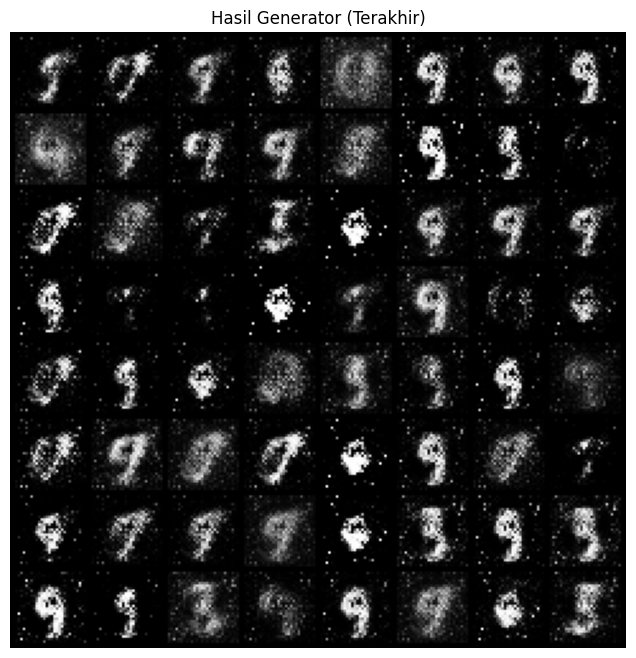

In [8]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.title("Loss Selama Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Tampilkan hasil gambar generator terakhir
with torch.no_grad():
    gen_images = generator(fixed_noise).detach().cpu()
grid = make_grid(gen_images, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Hasil Generator (Terakhir)")
plt.show()

In [9]:
#Simpan Model GAN
torch.save(generator.state_dict(), "/kaggle/working/models/generator.pth")
torch.save(discriminator.state_dict(), "/kaggle/working/models/discriminator.pth")